In [55]:
%pylab inline
%load_ext autoreload
%autoreload 2
import torch 
import torch.nn as nn 
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import io
import pickle
import tarfile

def fetch(url):
  import requests, os, hashlib, tempfile
  fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp) and os.stat(fp).st_size > 0:
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    print("fetching %s" % url)
    dat = requests.get(url).content
    with open(fp+".tmp", "wb") as f:
      f.write(dat)
    os.rename(fp+".tmp", fp)
  return dat

def load_cifar():
  print("loading data")
  tt = tarfile.open(fileobj=io.BytesIO(fetch("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")), mode="r:gz")
  db = pickle.load(tt.extractfile("cifar-10-batches-py/data_batch_1"), encoding="bytes")
  X = db[b'data'].reshape((-1, 3, 32, 32))
  Y = np.array(db[b'labels'])
  print("loaded data")
  return X, Y

loading data
loaded data
6


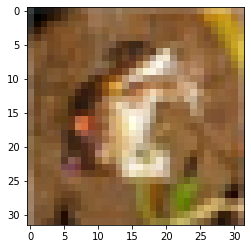

In [58]:
X_train, Y_train = load_cifar()
imshow(X_train[0].T)
print(Y_train[0]) # apparently a frog

In [72]:
from efficientnet_pytorch import EfficientNet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size= 64
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=batch_size)
  X = torch.tensor(X_train[samp]).float().to(device)
  Y = torch.tensor(Y_train[samp]).long().to(device)
  optimizer.zero_grad()
  out = model(X)
  accuracy = (out.argmax(dim=1) == Y).float().mean()
  loss = loss_fn(out, Y)
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  accuracies.append(accuracy.item())
  t.set_description(f"loss {loss:.4f} accuracy {accuracy:.4f}")

Loaded pretrained weights for efficientnet-b0


loss 0.3591 accuracy 0.8594: 100%|██████████| 1000/1000 [01:04<00:00, 15.53it/s]


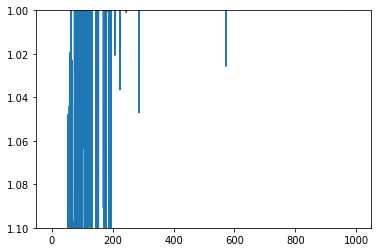

In [79]:
ylim(1.1)
plot(losses)
plot(accuracies)